# Setup

In [29]:
# import your standard packages
%run ../../../global-tools/start.py

# import your local functions
sys.path.insert(1, '../../local-tools/')
from local_functions import *

# make sure the figures plot inline rather than at the end
%matplotlib inline


# get data
path = '/home/jennap/projects/LRGROUP/shared_data/chl-oc-cci/concatenated/'
chlinfn = 'ESACCI-OC-L3S-CHLOR_A-MERGED-1M_MONTHLY_4km_GEO_PML_OCx-fv5.0_1997_2020.nc'
ds = xr.open_dataset(path + chlinfn)
ds


Default Libraries Loaded.


<xarray.Dataset>
Dimensions:  (lat: 4320, lon: 8640, time: 274)
Coordinates:
  * time     (time) datetime64[ns] 1997-09-04 1997-10-01 ... 2020-06-01
  * lat      (lat) float64 -89.98 -89.94 -89.9 -89.85 ... 89.85 89.9 89.94 89.98
  * lon      (lon) float64 0.02083 0.0625 0.1042 0.1458 ... 359.9 359.9 360.0
Data variables:
    chlor_a  (time, lat, lon) float64 ...
Attributes:
    date_created:                      12/29/2020
    unmerged_data_url:                 https://climate.esa.int/en/projects/oc...
    geospatial_lat_units:              decimal degrees north (-90,90)
    geospatial_lon_units:              decimal degrees east (0,360)
    spatial_resolution:                4km nominal at equator
    geospatial_lat_resolution:         .04166666666666666666
    geospatial_lon_resolution:         .04166666666666666666
    number_of_bands_used_to_classify:  4
    number_of_optical_water_types:     14
    product_version:                   5.0
    processing_level:                  Leve

In [30]:
# Subset ------------------------------------------------#
# Create slice variables to subset domain before finding means
lat_slice = slice(-20, 30) # bounds inclusive
lon_slice = slice(35, 120) # bounds inclusive

# Get data, selecting lat/lon slice
mon_chl = ds['chlor_a'].sel(lat=lat_slice,lon=lon_slice)
lat = mon_chl.lat.values
lon = mon_chl.lon.values
mon_chl

<xarray.DataArray 'chlor_a' (time: 274, lat: 1200, lon: 2040)>
[670752000 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1997-09-04 1997-10-01 ... 2020-06-01
  * lat      (lat) float64 -19.98 -19.94 -19.9 -19.85 ... 29.85 29.9 29.94 29.98
  * lon      (lon) float64 35.02 35.06 35.1 35.15 ... 119.9 119.9 119.9 120.0
Attributes:
    units:                mg/m^3
    long_name:            Chlorophyll-a concentration in seawater, generated ...
    parameter_vocab_uri:  http://vocab.ndg.nerc.ac.uk/term/P011/current/CHLTVOLU
    standard_name:        mass concentration of chlorophyll-a in sea water

# Detrend

In [21]:
# stack lat and lon into a single dimension called allpoints
stacked = mon_chl.stack(allpoints=['lat','lon'])
# set places where there are nans to zero since polyfit can't deal with them
stacked_nonan = stacked.fillna(0)

# convert date to a number to polyfit can handle it
datenum = dates.date2num(stacked_nonan.time)
mon_chl_slope, mon_chl_intercept = np.polyfit(datenum, stacked_nonan, 1)

#reshape the data
mon_chl_slope = np.reshape(mon_chl_slope, mon_chl.shape[1:3])
mon_chl_intercept = np.reshape(mon_chl_intercept, mon_chl.shape[1:3])

# define a function to compute a linear trend of a timeseries
def linear_detrend(y):
    x = dates.date2num(y.time)
    m, b = np.polyfit(x, y, 1)
    # we need to return a dataarray or else xarray's groupby won't be happy
    return xr.DataArray(y - (m*x + b))

# apply the function over allpoints to calculate the trend at each point
mon_chl_dtrnd = stacked_nonan.groupby('allpoints').apply(linear_detrend)
# unstack back to lat lon coordinates
mon_chl_dtrnd = mon_chl_dtrnd.unstack('allpoints')

# fill all points we set originally to zero back to nan
mon_chl_dtrnd = mon_chl_dtrnd.where(~np.isnan(mon_chl))

/home/jennap/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


<function matplotlib.pyplot.legend(*args, **kwargs)>

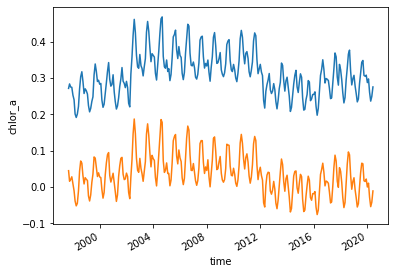

In [22]:
# find global means for comparison
stacked = mon_chl.stack(allpoints=['lat','lon'])
global_mean = stacked.mean(dim='allpoints',skipna=True)
global_mean.plot()

# find global means for comparison
stacked = mon_chl_dtrnd.stack(allpoints=['lat','lon'])
global_mean_dtrnd = stacked.mean(dim='allpoints',skipna=True)
global_mean_dtrnd.plot()
plt.legend

# Downsample to Seasonal Temporal Resolution

In [31]:
%%time

mon_chl_dtrnd = mon_chl
# seasonal
seas_chl_dtrnd = mon_chl_dtrnd.resample(time='QS-DEC').mean(dim="time")

/home/jennap/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CPU times: user 10min 17s, sys: 35.1 s, total: 10min 52s
Wall time: 1min 33s


# Find Climatologies 
Resources: [link](http://xarray.pydata.org/en/stable/examples/monthly-means.html)

In [32]:
%%time
# -------------------------------------------
# weighted seasonal
# -------------------------------------------

# get months
month_length = mon_chl_dtrnd.time.dt.days_in_month

# calculate the weights by grouping by 'time.season'.
weights = month_length.groupby('time.season') / month_length.groupby('time.season').sum()

# calculate the weighted average
chl_seas_clim = (mon_chl_dtrnd * weights).groupby('time.season').sum(dim='time')   

# set the places that are now zero from the weights to nans
chl_seas_clim = chl_seas_clim.where(chl_seas_clim != 0,np.nan) # for some reason .where sets the locations not in the condition to nan by default

# -------------------------------------------
# monthly
# -------------------------------------------

chl_mon_clim = mon_chl_dtrnd.groupby('time.month').mean('time') 

/home/jennap/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CPU times: user 11min 18s, sys: 1min 4s, total: 12min 22s
Wall time: 1min 6s


# Find Anomalies

In [33]:
%%time
# monthly avg data - monthly climatology
mon_chl_mon_anom = mon_chl_dtrnd.groupby('time.month') - chl_mon_clim

# seasonal avg data - seasonal climatology
seas_chl_seas_anom = seas_chl_dtrnd.groupby('time.season') - chl_seas_clim

CPU times: user 7min 34s, sys: 53.3 s, total: 8min 28s
Wall time: 17.2 s


In [34]:
# convert to xarray dataset
ds=xr.Dataset(coords={'lon': mon_chl_dtrnd.lon,
                    'lat': mon_chl_dtrnd.lat,
                    'time': mon_chl_dtrnd.time})

# add variables to dataset

ds["mon_chl"]=xr.DataArray(mon_chl_dtrnd,dims = ['time','lat', 'lon'],
                     coords =[mon_chl_dtrnd.time,mon_chl_dtrnd.lat,mon_chl_dtrnd.lon])

ds["seas_chl"]=xr.DataArray(seas_chl_dtrnd,dims = ['season_time','lat', 'lon'],
                     coords =[seas_chl_dtrnd.time,mon_chl_dtrnd.lat,mon_chl_dtrnd.lon])

# clim
ds["chl_mon_clim"]=xr.DataArray(chl_mon_clim,dims = ['month','lat', 'lon'],
                     coords =[chl_mon_clim.month,mon_chl_dtrnd.lat,mon_chl_dtrnd.lon])
ds["chl_seas_clim"]=xr.DataArray(chl_seas_clim,dims = ['season','lat', 'lon'],
                     coords =[chl_seas_clim.season,mon_chl_dtrnd.lat,mon_chl_dtrnd.lon])


# anom
ds["mon_chl_mon_anom"]=xr.DataArray(mon_chl_mon_anom,dims = ['time','lat', 'lon'],
                     coords =[mon_chl_mon_anom.time,mon_chl_dtrnd.lat,mon_chl_dtrnd.lon])
ds["seas_chl_seas_anom"]=xr.DataArray(seas_chl_seas_anom,dims = ['season_time','lat', 'lon'],
                     coords =[seas_chl_seas_anom.time,mon_chl_dtrnd.lat,mon_chl_dtrnd.lon])


In [35]:
import os

outfn = 'chl_4km_monthly_processed.nc'

# delete if already present
if os.path.isfile(outfn):
    os.remove(outfn)

ds.to_netcdf(outfn,mode='w',format = "NETCDF4")

ds

<xarray.Dataset>
Dimensions:             (lat: 1200, lon: 2040, month: 12, season: 4, season_time: 92, time: 274)
Coordinates:
  * lon                 (lon) float64 35.02 35.06 35.1 ... 119.9 119.9 120.0
  * lat                 (lat) float64 -19.98 -19.94 -19.9 ... 29.9 29.94 29.98
  * time                (time) datetime64[ns] 1997-09-04 ... 2020-06-01
  * season_time         (season_time) datetime64[ns] 1997-09-01 ... 2020-06-01
  * month               (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * season              (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    mon_chl             (time, lat, lon) float64 2.473 1.918 1.767 ... nan nan
    seas_chl            (season_time, lat, lon) float64 2.473 1.918 ... nan nan
    chl_mon_clim        (month, lat, lon) float64 3.419 2.839 2.228 ... nan nan
    chl_seas_clim       (season, lat, lon) float64 3.33 2.666 2.099 ... nan nan
    mon_chl_mon_anom    (time, lat, lon) float64 -0.5904 -0.3318 ... nan nan
    seas_chl_seas_anom  (